In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

#ktis19 modules
from starter_code.visualize import visualize
from starter_code.utils import load_case

#own modules
from modules.NeuralNetwork import makeModel
from modules.visualizeSlider import cube_show_slider
from modules.preprocessing import preprocess_X, preprocess_y, scale

#changing to half precision due to memory limitations
import keras.backend as K
# K.set_floatx('float16')
# K.set_epsilon(1e-4)

Using TensorFlow backend.


In [2]:
volume, segmentation = load_case(123)
X = preprocess_X(volume)
y = preprocess_y(segmentation)

IMG_WIDTH = X.shape[2]
IMG_HEIGHT = X.shape[1]
IMG_DEPTH = X.shape[3]
IMG_SLICES = X.shape[0]
# X = np.expand_dims(X, 3)
# y = tf.keras.utils.to_categorical(y)

In [3]:
y.shape

(389, 512, 512, 2)

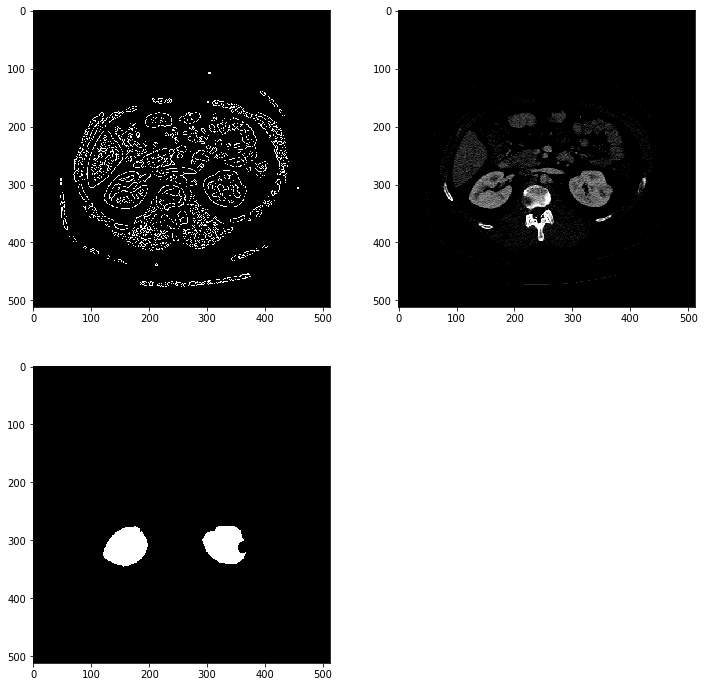

In [4]:
slice = 130
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(X[slice,:,:,1], cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(X[slice,:,:,0], cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(y[slice,:,:,0], cmap='gray')

In [5]:
model = makeModel(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='accuracy'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.ModelCheckpoint('saved_models/model1.h5', verbose=1, save_best_only=True)
]

0-179 Train set, 180-209 val_set, 210-299 test

In [7]:
case_numbers = np.delete(np.arange(0, 209, 1), [158, 159, 170, 202])
case_numbers_val = case_numbers[179:]
case_numbers_train = case_numbers[:179]

In [8]:
for n_img in tqdm(case_numbers_train):

    #load and preprocess train data
    volume, segmentation = load_case(n_img)
    X = preprocess_X(volume)
    y = preprocess_y(segmentation)
    print('\nloaded case {} as train data'.format(n_img))

    #load and preprocess random validation image
    random_val_index = case_numbers_val[np.random.randint(0, len(case_numbers_val))]
    volume_val, segmentation_val = load_case(random_val_index)
    X_val = preprocess_X(volume_val)
    y_val = preprocess_y(segmentation_val)
    print('\nloaded case {} as validation data'.format(random_val_index))

    #fit model
    results = model.fit(X, y, batch_size=8, epochs=4, callbacks=callbacks, verbose=1, validation_data=(X_val, y_val))

0%|          | 0/179 [00:00<?, ?it/s]
loaded case 0 as train data

loaded case 207 as validation data
Train on 611 samples, validate on 140 samples
Epoch 1/4
608/611 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9656
Epoch 00001: val_loss improved from inf to 0.00033, saving model to saved_models/model1.h5
611/611 [==============================] - 33s 53ms/sample - loss: 0.0010 - accuracy: 0.9658 - val_loss: 3.3078e-04 - val_accuracy: 0.9999
Epoch 2/4
608/611 [============================>.] - ETA: 0s - loss: 6.3692e-04 - accuracy: 0.9990
Epoch 00002: val_loss improved from 0.00033 to 0.00033, saving model to saved_models/model1.h5
611/611 [==============================] - 23s 38ms/sample - loss: 6.4608e-04 - accuracy: 0.9990 - val_loss: 3.2986e-04 - val_accuracy: 0.9999
Epoch 3/4
608/611 [============================>.] - ETA: 0s - loss: 6.2105e-04 - accuracy: 0.9993
Epoch 00003: val_loss improved from 0.00033 to 0.00030, saving model to saved_models/model1

KeyboardInterrupt: 

In [22]:
model.save('saved_models\model_big_4_test')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models\model_big_4_test\assets


In [9]:
predicted = model.predict(X)

In [10]:
def dice_score(y_pred, y_test):
    return np.sum(y_pred)*2.0 / (np.sum(y_pred) + np.sum(y_test))

In [11]:
dice_score(predicted[:,:,:,1], y[:,:,:,1])

1.957743730065847

In [19]:
%matplotlib qt4
cube_show_slider(cube=predicted[:,:,:,0], axis=0, cmap='gray')

In [13]:
# volume, segmentation = load_case(123)
# X = volume.get_data()
# X = np.expand_dims(X, 3)
# model = tf.keras.models.load_model('model_big_1')

# print(segmentation.shape)
# nifty = nib.Nifti1Image(segmentation, volume.affine, volume.header)